In [466]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt

# Read image metadata

Use PIL to read image metadata. Metadata has no use as of now. Keep this snippet if it is needed in the future.

In [2]:
from PIL import Image
from PIL.TiffTags import TAGS

with Image.open('data/1941.tiff') as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag.keys()}

In [3]:
meta_dict

{'ImageWidth': (2007,),
 'ImageLength': (2048,),
 'BitsPerSample': (16,),
 'Compression': (1,),
 'PhotometricInterpretation': (1,),
 'ResolutionUnit': (3,),
 'StripOffsets': (8,),
 'Orientation': (4,),
 'SampleFormat': (1,),
 'SamplesPerPixel': (1,),
 'RowsPerStrip': (2048,),
 'StripByteCounts': (8220672,),
 'XResolution': ((4294967295, 8677676),),
 'YResolution': ((4294967295, 8677676),),
 'PlanarConfiguration': (1,)}

# Helper functions

Implement any commonly used functions here.

In [4]:
# Plot images as a grid
def my_plot(rows, cols, images):
    if len(images) > rows * cols:
        raise Exception('Number of images passed exceeds dimensions of grid')
    
    subfigs = []
    fig = plt.figure(figsize = (rows * 10, cols * 10))
    
    for i in range(rows):
        for j in range(cols):
            subfigs.append(fig.add_subplot(rows, cols, i * cols + j + 1))
    
    for i in range(len(images)):
        subfigs[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)

In [410]:
# Convert all datasets to videos (for better visualization)
from pathlib import Path

def get_tiff_dict(path):
    tiff_files = Path(path).rglob('*.tiff')
    tiff_dirs = {}
    for tiff_file in tiff_files:
        tiff_file = str(tiff_file)
        if tiff_file.split('/')[-1][0] == '.':
            continue
            
        tiff_dir = '/'.join(tiff_file.split('/')[: -1])
        if tiff_dir in tiff_dirs.keys():
            tiff_dirs[tiff_dir].append(tiff_file)
        else:
            tiff_dirs[tiff_dir] = [tiff_file]
    
    return tiff_dirs

def create_tiff_videos(path):
    tiff_dirs = get_tiff_dict(path)
    
    for tiff_dir in tiff_dirs.keys():
        size = ()
        
        img = cv2.imread(tiff_dirs[tiff_dir][0])
        height, width, layers = img.shape
        size = (width, height)
        save_path = 'data/' + tiff_dir.split('/')[-1]

        out = cv2.VideoWriter(save_path + '.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
        
        for tiff_file in sorted(tiff_dirs[tiff_dir]):
            img = cv2.imread(tiff_file)
            out.write(img)
        
        out.release()

# create_tiff_videos('/media/chethan749/Honeycomb/combined/')

In [411]:
# Normalize the image to improve contrast
def normalize(img):
    return np.array((img - np.min(img)) / (np.max(img) - np.min(img)) * 255, dtype='uint8')

# Read data

Read and plot some sample images and their normalized images

In [459]:
img1 = cv2.imread('data/0703.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/1941.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

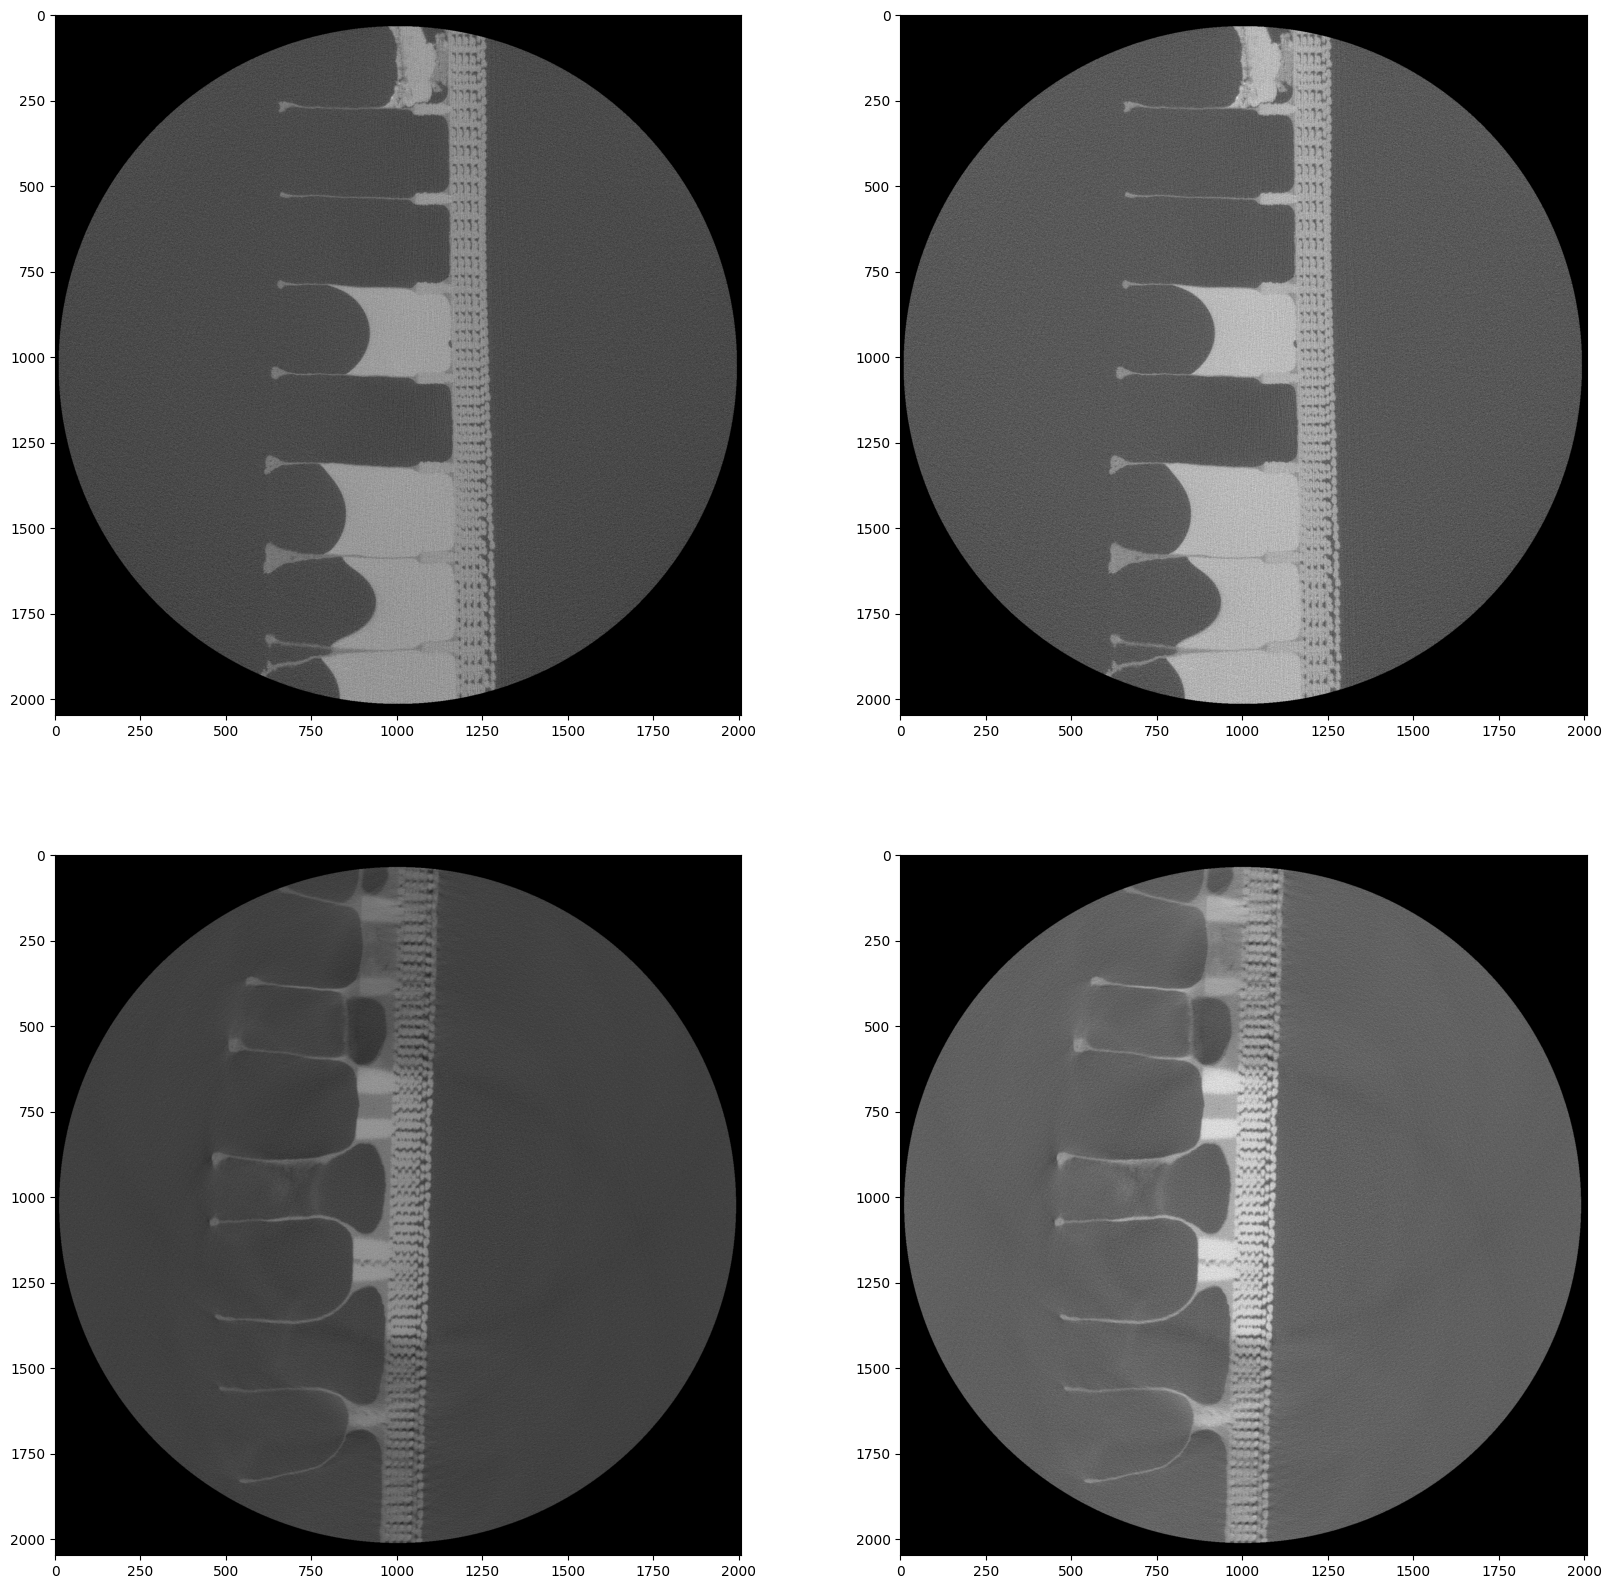

In [460]:
my_plot(2, 2, [img1, normalize(img1), img2, normalize(img2)])

# Initial analysis - Simple image processing operations

* Gaussian Blur to denoise the image

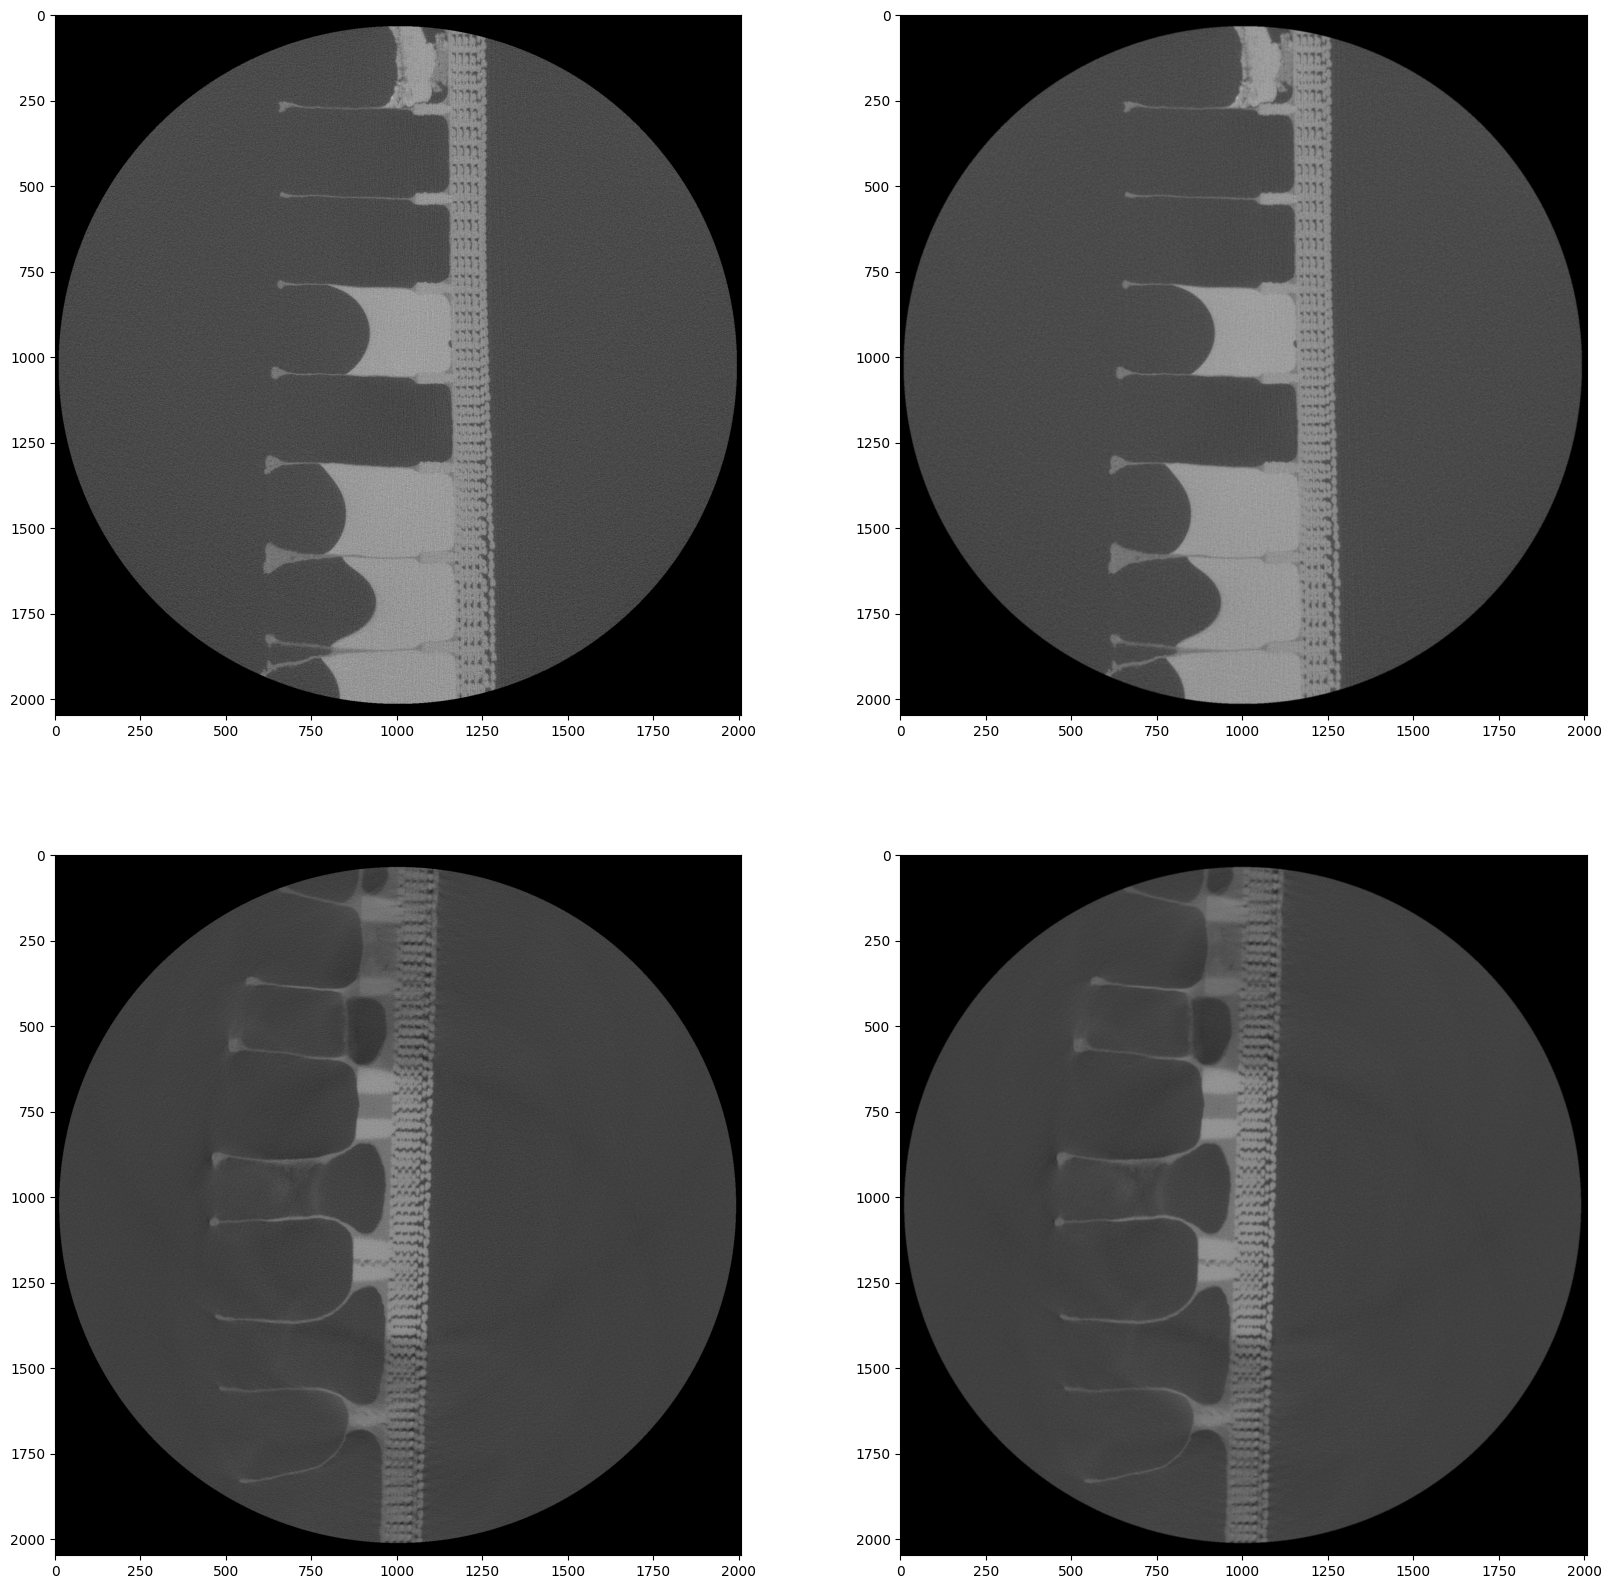

In [462]:
# Gaussian blur to remove noise
blurred_img1 = cv2.GaussianBlur(img1,(5,5),0)
blurred_img2 = cv2.GaussianBlur(img2,(5,5),0)

my_plot(2, 2, [img1, blurred_img1, img2, blurred_img2])

## Threshold and Contour

* Thresholding produces a good segmentation of the honeycomb when given the right threshold value, but finding the right threshold value is a challenge.
* The threshold value used below is hardcoded based on trial and error and this would not be an optimal value for every single frame.

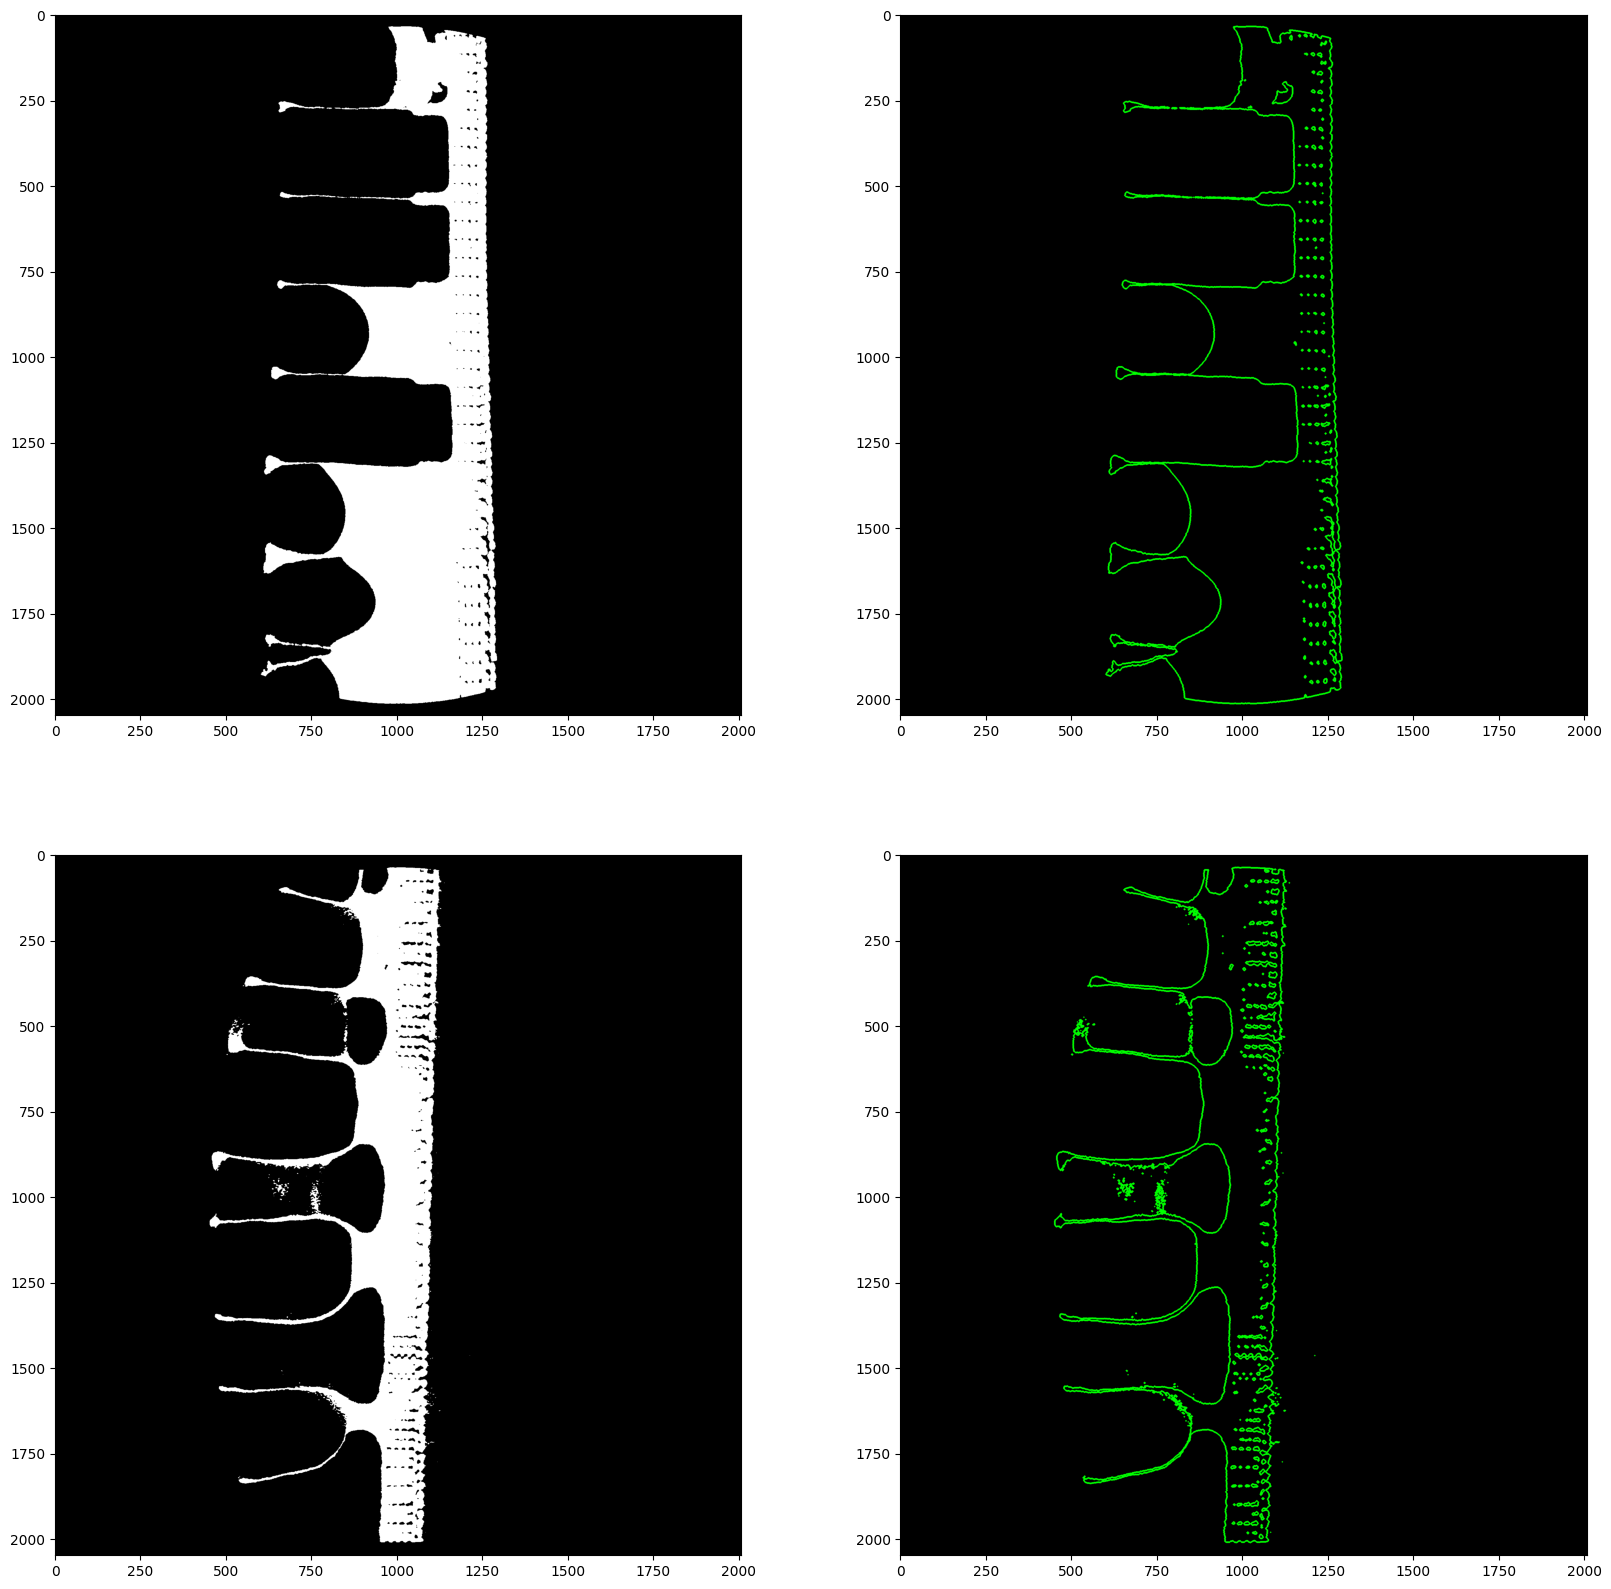

In [495]:
# Threshold and get contours. TODO: Any ways to automate finding threshold value?
def get_thresh_contours(img):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(5,5),0)
    # Threshold value of 120 is chosen based on trial and error
    ret, thresh = cv2.threshold(blurred_img, 120, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_thresh_contours(blurred_img1)
thresh2, contour_img2 = get_thresh_contours(blurred_img2)

my_plot(2, 2, [thresh1, contour_img1, thresh2, contour_img2])

Due to the limitations of regular thresholding, as mentioned above, adaptive thresholding is attempted instead.
* Hardcoding values is not necessary, however some parameters like the kernel size and C value must be given (Refer to OpenCV docs)
* Produces good results but the output is very noisy. Moreover, some of the foreground is lost during this process
* Some morphologival operations are necessary to clean the segmented image

array([  0, 255], dtype=uint8)

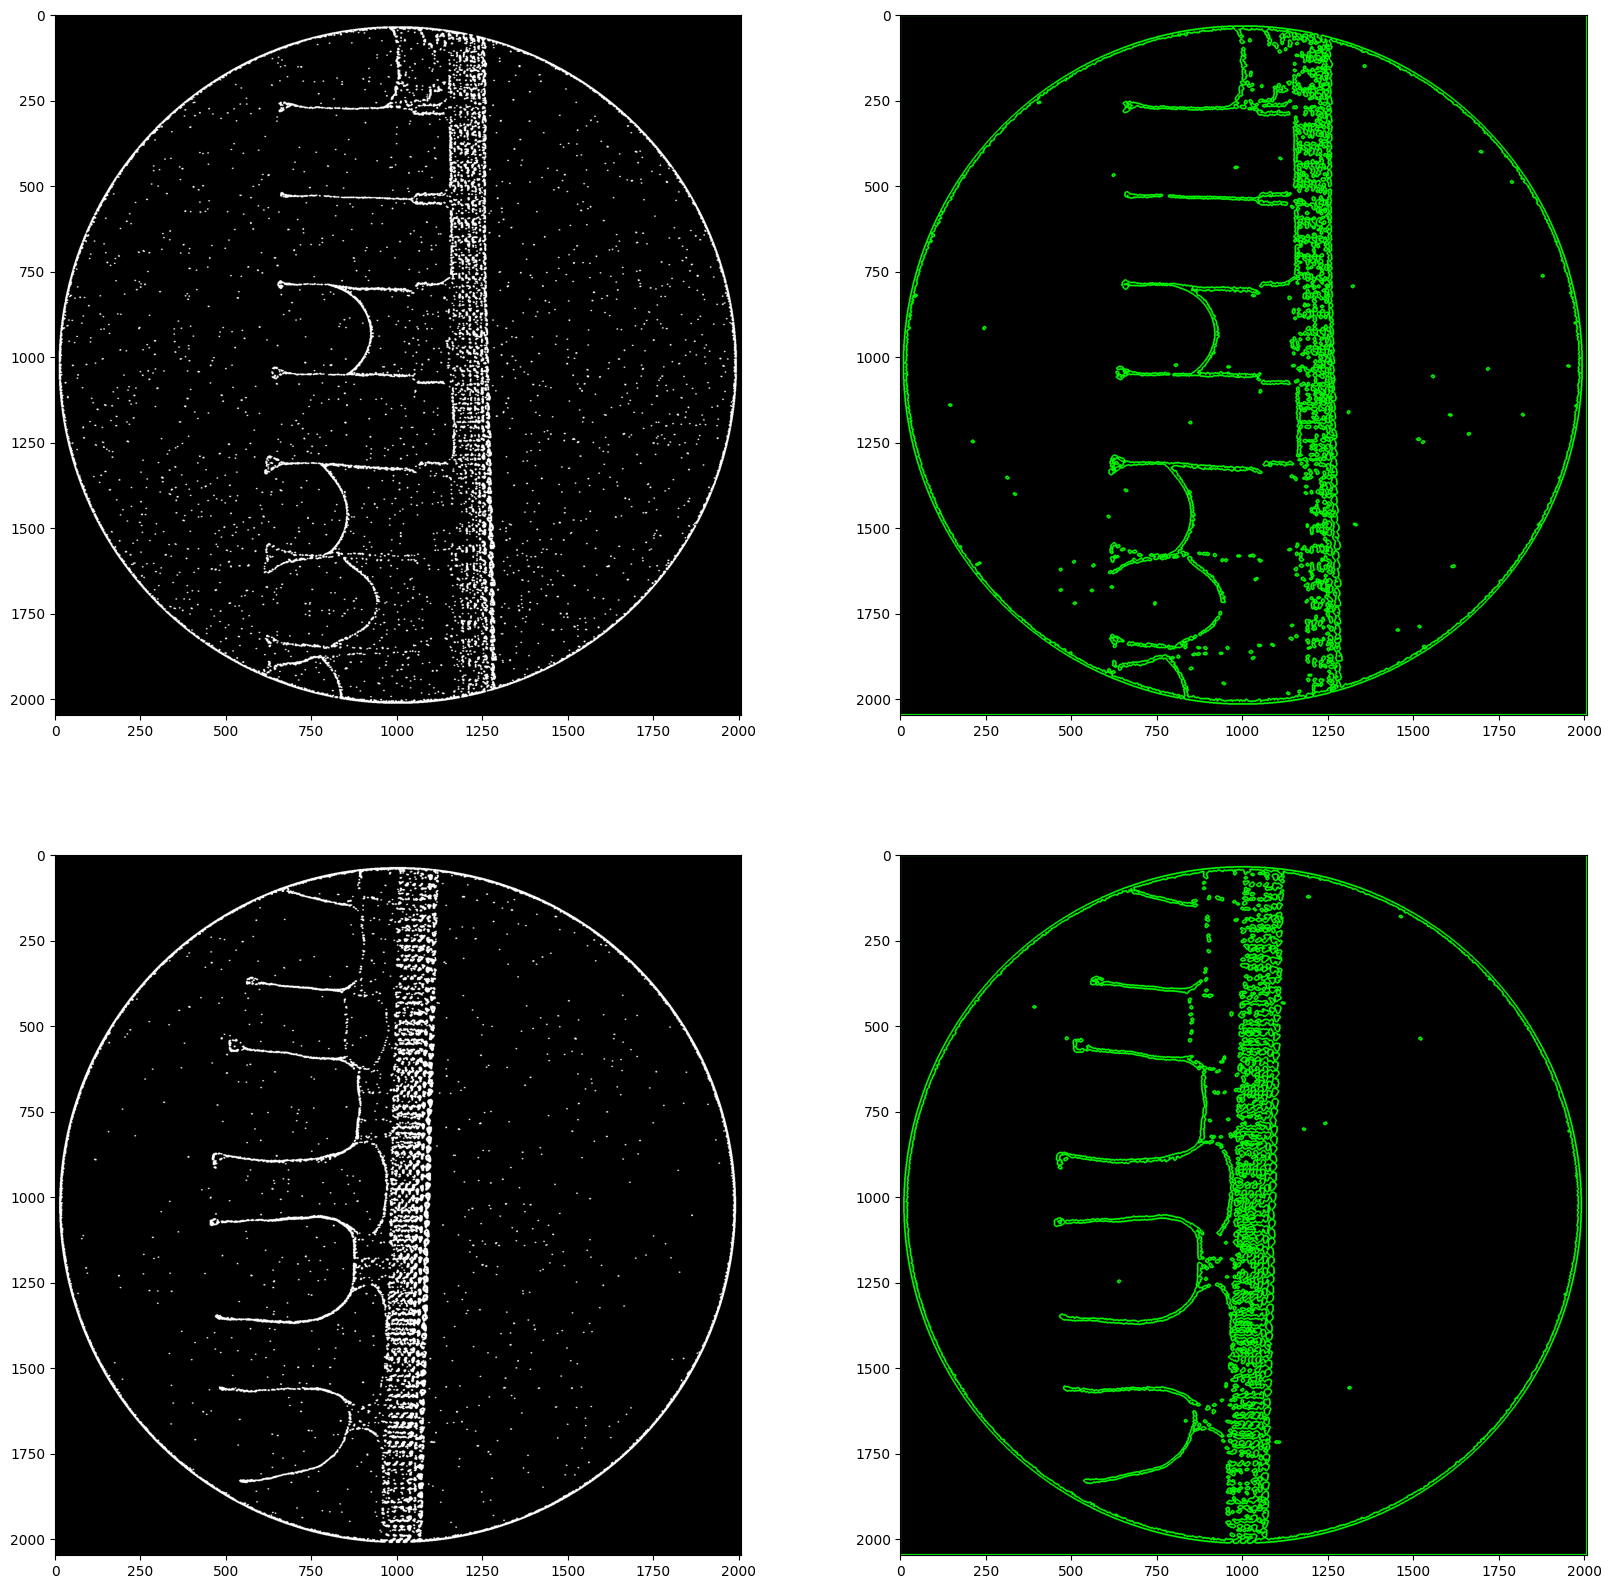

In [494]:
def get_adaptive_thresh_contours(img):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(7,7),0)
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, -2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    # Find contours and only keep contours that are relatively big (i.e., not noise)
    contours, hierarchy = cv2.findContours(255 - thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 42:
            new_contours.append(contour)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, new_contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_adaptive_thresh_contours(blurred_img1)
thresh2, contour_img2 = get_adaptive_thresh_contours(blurred_img2)

my_plot(2, 2, [thresh1, contour_img1, thresh2, contour_img2])
np.unique(thresh1)

# Edge detection

An automatic Canny edge detector is used. It takes a sigma value as input which is a measure of the range of lower and upper bound that cv2.Canny takes for edge segmentation.
* It is difficult to fine-tune a sigma value that works for all possible scenarios
* Edges are hit-or-miss and not consistent

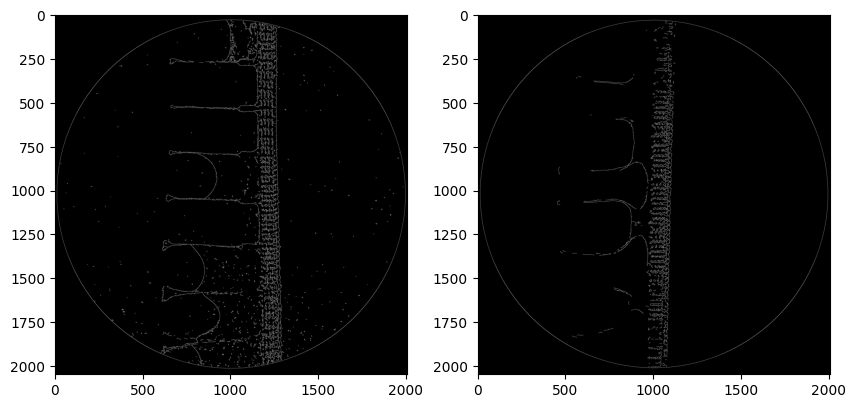

In [501]:
# Auto canny edge detector where lower and upper bounds are calculated automatically
def auto_canny(img, sigma = 0.33):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(7,7),0)
    v = np.median(blurred_img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(img, lower, upper)

edges1 = auto_canny(blurred_img1)
edges2 = auto_canny(blurred_img2)
    
my_plot(1, 2, [edges1, edges2])

# Background subtraction

The idea is to learn the background of X-ray images in a dataset using the running average method. Then subtract the learnt background image from each image in the dataset to get foreground only

Note: Works on the assumption that background remains fairly static and only foreground changes

**Observations:**
* Works well in the absence of honey, as presence of honey increases pixel intensities in the background image and this causes loss of honeycomb structures when background subtraction is performed.
* Foreground image is noisy and needs morphological operations to clean the image. Foreground produced is not as clean as the histogram method.
* Honey still remains part of the foreground.

In [343]:
# Compute background using running average
def get_background(img_files, alpha = 0.005):
    avg_img = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    for img_path in img_files[1:]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img,(7,7),0)
        avg_img = (1 - alpha) * avg_img + (alpha) * img
        avg_img = cv2.GaussianBlur(avg_img,(7,7),0)
    
    return np.array(avg_img, dtype='uint8')

In [382]:
# Background subtraction to get foreground image
def get_foreground(img, background):
    diff = np.maximum(0, img.astype(np.int32) - background.astype(np.int32))
    img = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    ret, thresh = cv2.threshold(img, 0.5, 255, 0)
    thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)))
    
    return thresh

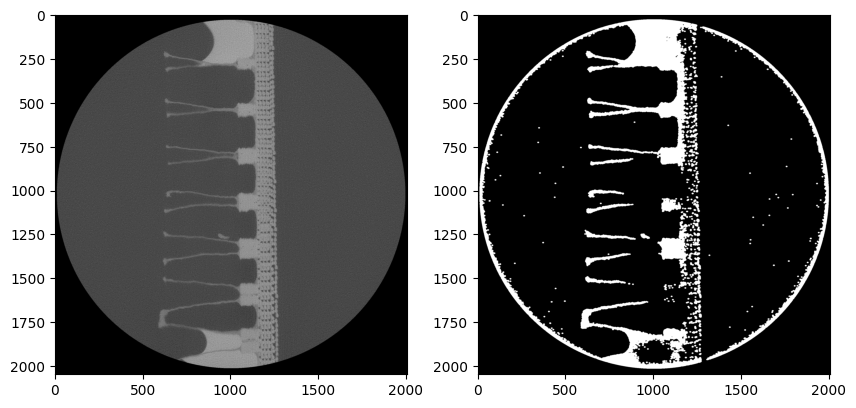

In [383]:
img = cv2.imread(sorted(tiff_dirs[list(sorted(tiff_dirs.keys()))[2]])[200], cv2.IMREAD_GRAYSCALE)
# background = get_background(sorted(tiff_dirs[list(sorted(tiff_dirs.keys()))[2]]))
diff = get_foreground(img, background)

my_plot(1, 2, [img, diff])

In [345]:
tiff_dirs = get_tiff_dict('/media/chethan749/Honeycomb/combined/')

for tiff_dir in sorted(tiff_dirs.keys()):
    print('Begin computing background of ' + tiff_dir)
    background = get_background(tiff_dirs[tiff_dir])
    print('Finish computing background of ' + tiff_dir)
    out = cv2.VideoWriter('data/solution/' + tiff_dir.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (background.shape[1], background.shape[0]))

    print('Begin computing foreground of ' + tiff_dir)
    for file in sorted(tiff_dirs[tiff_dir]):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        thresh = get_foreground(img, background)
        out.write(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))
    print('Finish computing foreground of ' + tiff_dir)

    out.release()

Begin computing background of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon
Finish computing background of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon
Begin computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon
Finish computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_in_1/wax_3x_zoomed_in_1_recon
Begin computing background of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon
Finish computing background of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon
Begin computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon
Finish computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon
Begin computing background of /media/chethan

## Histogram for images

This method to segment foreground honeycomb from the background worked best. The method is implemented as follows:
* Get the histogram for the image
* Remove count of black pixels as they are the highest and not relevant to our task
* After removing black pixels, the highest peak corresponds to background. Make all the pixels corresponding to this peak black, effectively removing background
* Generate a mask of the foreground generated in the previous step
* Open and dilate the mask to remove noise and make honeycomb structures clear

TODOs:
* Honey still remains part of foreground - Segment it out
* Segment out plastic

In [463]:
def get_hist_fg(img):
#     img = normalize(img)
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

    hist = cv2.calcHist([blurred_img],[0],None,[256],[0,256])
    hist = np.squeeze(hist)
    hist[0] = 0

    peak = np.argmax(hist[:128])
    start = peak
    for i in range(peak, 256):
        if hist[i] < 0.1 * hist[peak]:
            break
        start += 1
    
    mask = np.where(img > start, 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image, mask, hist

In [458]:
# This snippet generates videos of foreground extracted using the histogram method above for all datasets
dataset_path = '/media/chethan749/Honeycomb/combined/'
hist_solution_path = '/home/chethan749/honeycomb_analysis/data/solution/hist/'

tiff_dirs = get_tiff_dict(dataset_path)

if not os.path.isdir(path):
    os.makedirs(path)      
    
for tiff_dir in sorted(tiff_dirs.keys()):
    temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(hist_solution_path + tiff_dir.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

    print('Begin computing foreground of ' + tiff_dir)
    for file in sorted(tiff_dirs[tiff_dir]):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        masked_image, thresh, hist = get_hist_fg(img)
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish computing foreground of ' + tiff_dir)

    out.release()

Begin computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1o5/hc_1o5/hc_1o5_2022-04-01_102637/0.4X 80kV/hc_1o5_0.4X 80kV_recon
Finish computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1o5/hc_1o5/hc_1o5_2022-04-01_102637/0.4X 80kV/hc_1o5_0.4X 80kV_recon
Begin computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1x/hc_1x/hc_1x/hc_1x_2022-04-14_175649/0.4X 80kV/hc_1x_0.4X 80kV_recon
Finish computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1x/hc_1x/hc_1x/hc_1x_2022-04-14_175649/0.4X 80kV/hc_1x_0.4X 80kV_recon
Begin computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1x/hc_1x/hc_1x_2022-04-14_175649/0.4X 80kV/hc_1x_0.4X 80kV_recon
Finish computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_1x/hc_1x/hc_1x_2022-04-14_175649/0.4X 80kV/hc_1x_0.4X 80kV_recon
Begin computing foreground of /media/chethan749/Honeycomb/combined/Beeswax_2x/hc_2x/hc_2x_2022-04-05_141432/0.4X 80kV/hc_2x_0.4X 80kV_rec

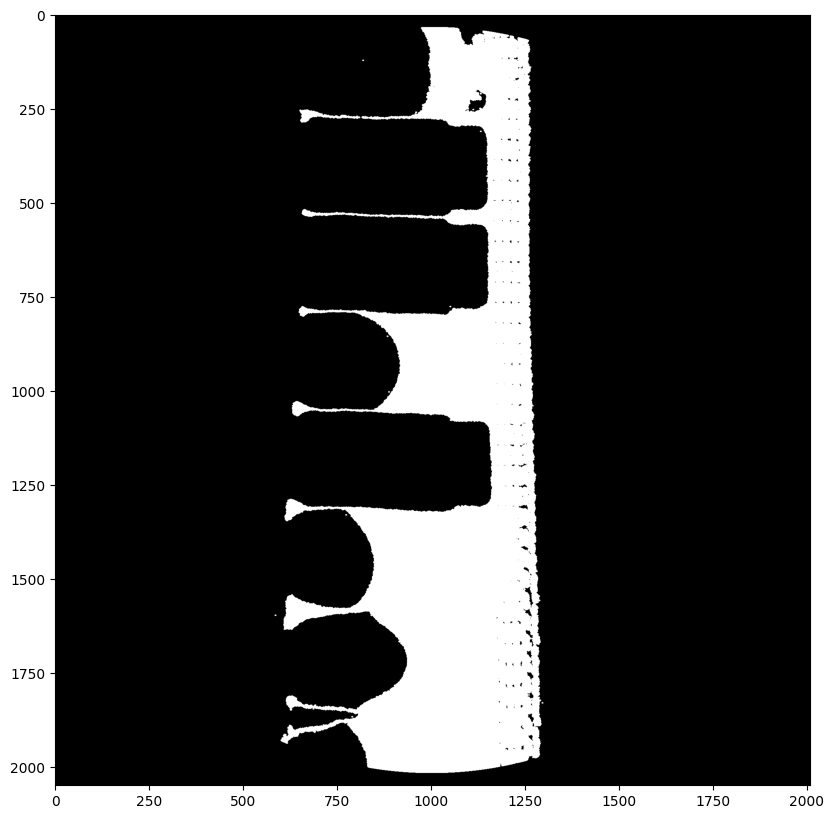

In [465]:
my_plot(1, 1, [get_hist_fg(img1)[1]])

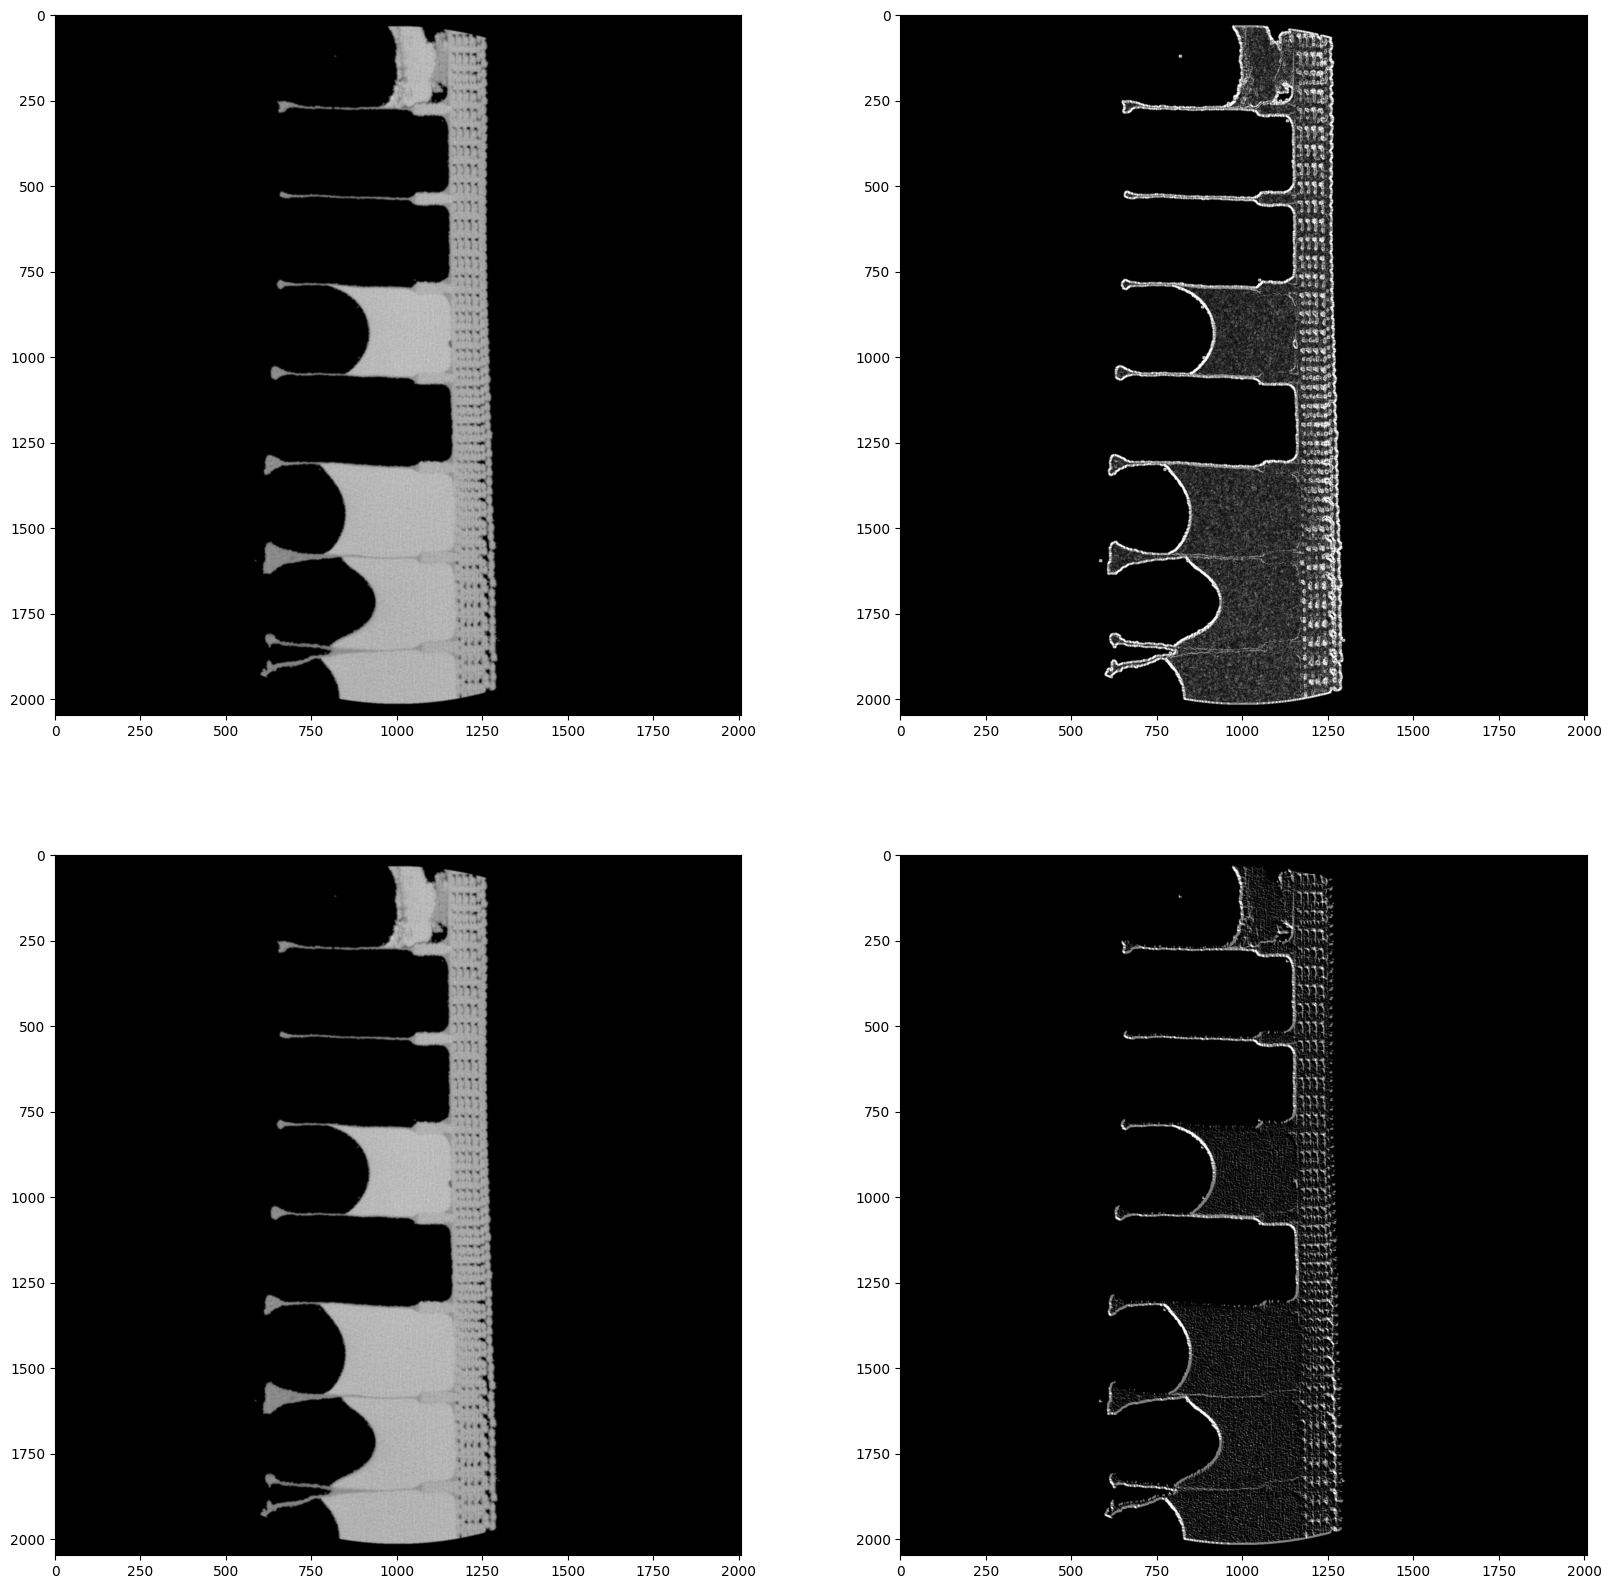

In [532]:
# Some experimentation on gradient operators
masked_img, thresh, hist = get_hist_fg(img1)
masked_img = normalize(masked_img)
masked_img = cv2.GaussianBlur(masked_img, (7, 7), 0)

# Scharr
ksize = -1
gX = cv2.Sobel(masked_img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(masked_img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
# the gradient magnitude images are now of the floating point data
# type, so we need to take care to convert them back a to unsigned
# 8-bit integer representation so other OpenCV functions can operate
# on them and visualize them
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
# combine the gradient representations into a single image
scharr = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

kernelx = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
kernely = np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
img_prewittx = cv2.filter2D(masked_img, -1, kernelx)
img_prewitty = cv2.filter2D(masked_img, -1, kernely)
prewitt = cv2.addWeighted(img_prewittx, 0.5, img_prewitty, 0.5, 0)

my_plot(2, 2, [masked_img, scharr, masked_img, prewitt])

# Superpixel segmentation

Experimentation only. Can this be used to remove honey?

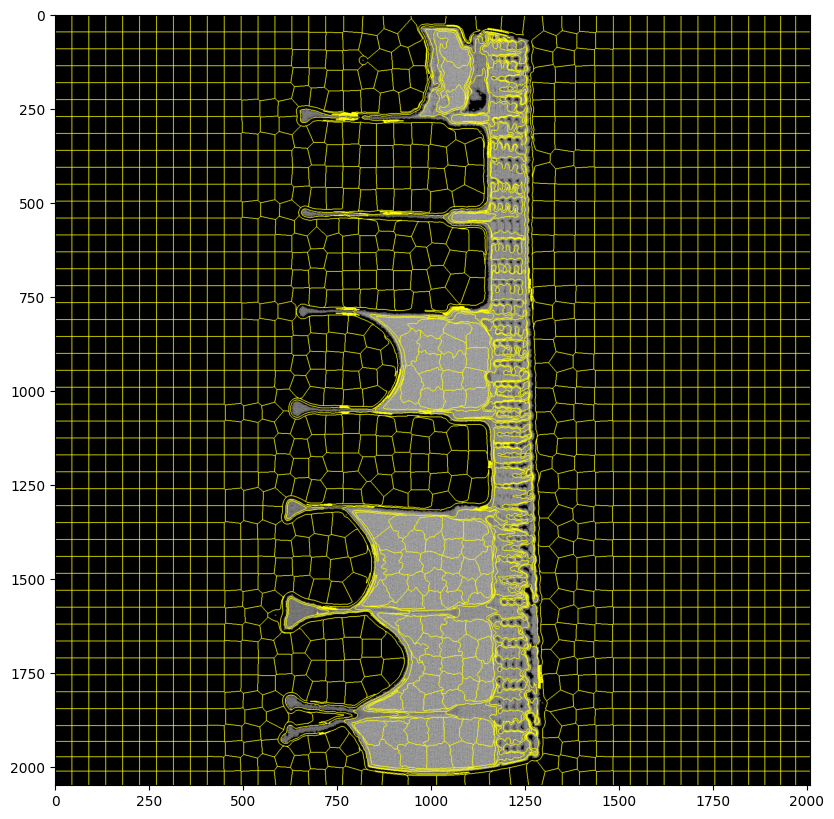

In [497]:
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

masked_img, thresh, hist = get_hist_fg(img1)
segments = slic(img_as_float(masked_img), compactness = 0.01, n_segments = 2000, sigma = 5)

# show the plots
my_plot(1, 1, [mark_boundaries(masked_img, segments)])